In [1]:
import vmas

import torch
import torch.nn as nn
from torch import multiprocessing

import matplotlib.pyplot as plt
import numpy as np

is_ipython = 'inline' in plt.get_backend()
if is_ipython:
    from IPython import display

In [2]:
# Device
is_fork = multiprocessing.get_start_method() == 'fork'
device = (
    torch.device(0) if torch.cuda.is_available() and not is_fork else torch.device('cpu')
)
vmas_device = device

# Environment
scenario_name = "navigation"

num_epochs = 1024  # Total number of training epochs, i.e. number of steps
max_steps = 256  # Episode steps before reset
num_vmas_envs = 1  # Number of vectorized environments to simulate at once

n_agents = 1 # Number of agents in the environment

In [3]:
env = vmas.make_env(
    scenario=scenario_name, # Name of the scenario
    num_envs=num_vmas_envs,
    continuous_actions=False,  # Use discrete actions
    max_steps=max_steps,
    device=vmas_device,
    dict_spaces=True, # Use a dictionary for the observation and action spaces, instead of a tuple

    # Scenario custom args
    enforce_bounds=True, # Enforce boundaries
    n_agents=n_agents,
)

print("Action spaces:", env.action_space)
print("Observation spaces:", env.observation_space)

# Get list of agents
agent_names = [agent.name for agent in env.agents]

# Get the name of the first agent
first_agent = agent_names[0]

# Obtain the size of the action space
action_size = env.action_space[first_agent].n

# Obtain the size of the observation space
observation_size = env.observation_space[first_agent].shape[0]

print("Action size:", action_size)
print("Observation size:", observation_size)
print("Environments size:", num_vmas_envs)

Action spaces: Dict('agent_0': Discrete(9))
Observation spaces: Dict('agent_0': Box(-inf, inf, (18,), float32))
Action size: 9
Observation size: 18
Environments size: 1


In [4]:
class ActorCritic(nn.Module):
    def __init__(self, obs_dim, act_dim, lr, hidden_dim=64):
        super(ActorCritic, self).__init__()

        self.actor = nn.Sequential(
            nn.Linear(obs_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, act_dim),
        )

        self.critic = nn.Sequential(
            nn.Linear(obs_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
        )
        
        self.optimizer = torch.optim.Adam(self.parameters(), lr=lr)

    def forward(self, obs):
        logits = self.actor(obs)

        # Apply softmax to get the policy
        policy = torch.softmax(logits, dim=-1)

        # Clamp policy probabilities to prevent NaNs and negative probabilities
        policy = torch.clamp(policy, min=1e-8, max=1.0)

        value = self.critic(obs)

        return policy, value

class ICM(nn.Module):
    def __init__(self, observation_size, action_size, hidden_size=128):
        super(ICM, self).__init__()
        # Inverse Model: Predict action from state and next state
        self.inverse_model = nn.Sequential(
            nn.Linear(2 * observation_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, action_size)
        )
        
        # Forward Model: Predict next state from state and action
        self.forward_model = nn.Sequential(
            nn.Linear(observation_size + action_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, observation_size)
        )

        self.mse_loss = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.001)

    def forward(self, state, next_state, action):
        # Predict action (inverse)
        inverse_input = torch.cat([state, next_state], dim=1)
        predicted_action = self.inverse_model(inverse_input)

        # Predict next state (forward)
        forward_input = torch.cat([state, action], dim=1)
        predicted_next_state = self.forward_model(forward_input)

        return predicted_action, predicted_next_state


In [5]:
class PPO:
    """
    Proximal Policy Optimization
    """
    def __init__(self, env, observation_size, action_size):
        self.env = env
        self.observation_size = observation_size
        self.action_size = action_size

        # Get list of agents names
        self.agents = [agent.name for agent in env.agents]

        # Entropy-Based Exploration Hyperparameters
        self.entropy_coeff = 0.02 # Entropy coefficient

        # PPO Hyperparameters
        self.gamma = 0.999 # Discount factor
        self.lmbda = 0.8 # Lambda for GAE
        self.lr = 0.0001 # Learning rate
        self.clip_epsilon = 0.2 # Clipping epsilon

        # Initialize the shared model
        self.shared_model = ActorCritic(observation_size, action_size, self.lr, hidden_dim=128).to(device)

        # Initialize the curiosity model
        self.icm = ICM(observation_size, action_size, hidden_size=128).to(device)
        self.intrinsic_reward_weight = 0.001
        

    def collect_rollout(self, env):
        """
        Runs the environment by a number of steps and returns the collected rollouts
        """
        rollouts = {agent.name: [] for agent in env.agents}
        obs = env.reset()
        dones = [False]

        steps = 0

        # Keep going until done
        while True:
            steps += 1
            actions = {}

            # Get the action of each agent
            for agent in env.agents:
                policy, _ = self.shared_model(obs[agent.name])

                # Ensure that the policy is normalized
                #policy = torch.softmax(policy, dim=-1)

                # Obtain the action from the policy
                action = torch.multinomial(policy, num_samples=1)
                actions[agent.name] = action

            next_obs, rewards, dones, _ = env.step(actions)

            for agent in env.agents:
                # Convert action to tensor with one-hot encoding
                action_tensor = nn.functional.one_hot(actions[agent.name], num_classes=self.action_size).float().squeeze(1).to(device)
                # Compute the intrinsic reward
                _, predicted_next_state = self.icm(obs[agent.name], next_obs[agent.name], action_tensor)
                intrinsic_reward = self.icm.mse_loss(predicted_next_state, next_obs[agent.name])

                # Compute the extrinsic reward
                extrinsic_reward = rewards[agent.name]

                # Combine the intrinsic and extrinsic rewards
                comb_rew = extrinsic_reward + intrinsic_reward * self.intrinsic_reward_weight

                # Store the rollouts
                rollouts[agent.name].append((obs[agent.name], actions[agent.name], comb_rew, next_obs[agent.name], dones))

            obs = next_obs
            if any(dones):
                break

        return rollouts, steps
    
    def train_icm(self, rollouts):
        """
        Trains the curiosity model using the rollouts previously collected
        """
        for agent in rollouts.keys():
            # Obtain the rollouts of each individual agent
            agent_rollouts = rollouts[agent]
            obs, actions, _, next_obs, _ = zip(*agent_rollouts)

            # Convert to tensors
            obs = torch.tensor(np.array(obs), dtype=torch.float32, device=device).squeeze(1)
            next_obs = torch.tensor(np.array(next_obs), dtype=torch.float32, device=device).squeeze(1)
            
            actions = nn.functional.one_hot(torch.tensor(actions), num_classes=self.action_size).float().squeeze(1).to(device)

            # Train the curiosity model
            predicted_actions, predicted_next_state = self.icm(obs, next_obs, actions)

            # Inverse loss
            inverse_loss = nn.CrossEntropyLoss()(predicted_actions, actions)

            # Forward loss
            forward_loss = self.icm.mse_loss(predicted_next_state, next_obs)

            # Total loss
            loss = inverse_loss + forward_loss * 0.2

            # Backpropagate
            self.icm.optimizer.zero_grad()
            loss.backward()
            self.icm.optimizer.step()

    def get_advantages(self, rollouts):
        """
        Computes the advantages for each agent using Generalized Advantage Estimation from the rollouts previously collected
        """
        advantages = {agent: [] for agent in rollouts.keys()}
        for agent in rollouts.keys():
            # Obtain the rollouts of each individual agent
            agent_rollouts = rollouts[agent]
            obs, _, rewards, next_obs, dones = zip(*agent_rollouts)

            # Convert to tensors
            obs_tensor = torch.tensor(np.array(obs), dtype=torch.float32, device=device)
            next_obs_tensor = torch.tensor(np.array(next_obs), dtype=torch.float32, device=device)
            dones_tensor = torch.tensor(np.array(dones), dtype=torch.float32, device=device)

            # Get the values from the critic
            _, values = self.shared_model(obs_tensor)
            _, next_values = self.shared_model(next_obs_tensor)

            # Remove extra dimensions
            values = values.squeeze()
            next_values = next_values.squeeze()

            # Compute the advantages
            returns = []
            advantage = 0.0
            for reward, value, next_value, done in zip(reversed(rewards), reversed(values), reversed(next_values), reversed(dones_tensor)):
                # GAE
                td_error = reward + (1 - done) * self.gamma * next_value - value
                advantage = td_error + self.gamma * self.lmbda * advantage
                returns.insert(0, advantage + value)  # GAE + baseline

            advantages[agent] = torch.tensor(returns, dtype=torch.float32, device=device) - values
        return advantages

    def ppo_update(self, rollouts, advantages, num_iters=5):
        all_obs, all_actions, all_adv = [], [], []

        # Collect all observations, actions and returns
        for agent in rollouts.keys():
            obs, actions, _, _, _ = zip(*rollouts[agent])
            all_obs.extend(obs)
            all_actions.extend(actions)
            all_adv.extend(advantages[agent])

        # Convert to tensors
        obs = torch.tensor(np.array(all_obs), dtype=torch.float32, device=device)
        actions = torch.tensor(all_actions, dtype=torch.int64, device=device).unsqueeze(1)
        adv = torch.tensor(all_adv, dtype=torch.float32, device=device)

        # Train the ICM module
        self.train_icm(rollouts)
        
        # Normalize advantages
        adv = (adv - adv.mean()) / (adv.std() + 1e-8)

        for _ in range(num_iters):
            # Forward pass the Network
                policy, values = self.shared_model(obs)
                old_policy = policy.detach()
                policy = torch.softmax(policy, dim=-1) # Normalize policy

                # Remove extra dimension from policy to match actions
                policy = policy.squeeze(1)
                old_policy = old_policy.squeeze(1)

                # Compute action probabilities for policy and old policy
                policy_probs = policy.gather(1, actions)  # Select action probabilities
                old_policy_probs = old_policy.gather(1, actions)  # Select old action probabilities

                # Compute the ratio of probabilities
                ratios = (policy_probs / old_policy_probs).squeeze()  # Remove extra dimension

                # Policy Loss
                clip = torch.clamp(ratios, 1 - self.clip_epsilon, 1 + self.clip_epsilon)
                policy_loss = -torch.min(ratios * adv, clip * adv).mean()

                # Value loss
                returns = adv + values.squeeze().detach()
                value_loss = nn.MSELoss()(values.squeeze(), returns)
                #value_loss = nn.MSELoss()(values.squeeze(), adv + values.squeeze())

                # Entropy loss
                entropy_loss = -(policy * torch.log(policy + 1e-8)).sum(dim=-1).mean()
                self.entropy_coeff = max(self.entropy_coeff * 0.995, 0.01)

                # Total loss
                loss = policy_loss + 0.5 * value_loss - self.entropy_coeff * entropy_loss

                # Backward pass
                self.shared_model.optimizer.zero_grad()
                loss.backward()

                # Clip gradients
                torch.nn.utils.clip_grad_norm_(self.shared_model.parameters(), max_norm=1.0)

                self.shared_model.optimizer.step()

    def plot_rewards(self, episode, max_episodes, history, show_result=False):
        plt.figure(1)

        if show_result:
            plt.title(f'Final Result:')
        else:
            plt.clf()
            plt.title(f"Episode {episode} of {max_episodes}")
        plt.xlabel('Episode')
        plt.ylabel('Steps taken')

        plt.plot(history)

        if is_ipython:
            if not show_result:
                display.display(plt.gcf())
                display.clear_output(wait=True)
            else:
                display.display(plt.gcf())

    def train(self, num_episodes=1000):
        """
        Trains the agents using Proximal Policy Optimization
        """

        step_history = []
        plt.ion()

        for episode in range(num_episodes):
            rollouts, steps = self.collect_rollout(self.env)
            advantages = self.get_advantages(rollouts)
            self.ppo_update(rollouts, advantages)

            step_history.append(steps)

            self.plot_rewards(episode, num_episodes, step_history)

            #print(f"Episode {episode + 1} with {steps} steps", end="\r", flush=True)
        
        self.plot_rewards(episode, num_episodes, step_history, show_result=True)
        plt.ioff()

    def test(self):
        """
        Tests the trained agents using the environment and renders the environment
        """
        while True:
            obs = self.env.reset()
            dones = [False]
            while not dones[0]:
                actions = {}
                # Get the action of each agent
                for agent in env.agents:
                    policy, _ = self.shared_model(obs[agent.name])

                    # Obtain the action from the policy
                    action = torch.multinomial(policy, num_samples=1)
                    actions[agent.name] = action
                
                obs, _, dones, _ = self.env.step(actions)

                self.env.render(mode="human")
    
    def play(self):
        """
        Runs the interactive environment
        """
        vmas.render_interactively(scenario_name, display_info=False)     

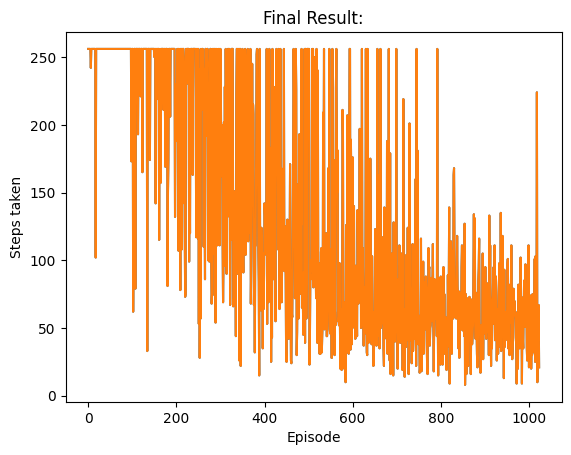

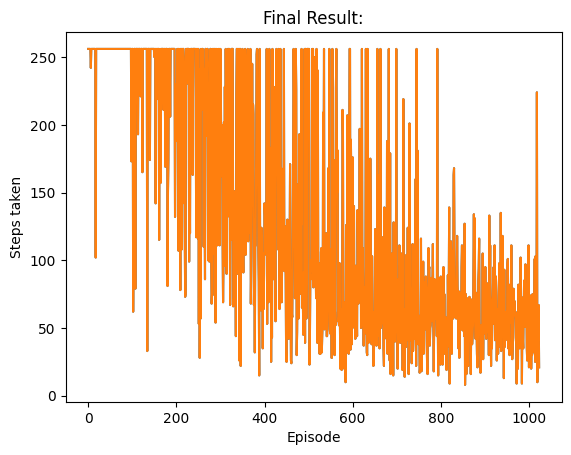

In [6]:
ppo = PPO(env, observation_size, action_size)
ppo.train(num_epochs)

In [7]:
ppo.test()

ArgumentError: argument 2: TypeError: wrong type

In [10]:
# Save the models
torch.save(ppo.shared_model.state_dict(), "models/ppo_model.pth")
torch.save(ppo.icm.state_dict(), "models/icm_model.pth")

In [ ]:
# Load the model
ppo.shared_model.load_state_dict(torch.load("ppo_model.pth"))
ppo.icm.load_state_dict(torch.load("icm_model.pth"))